<a href="https://colab.research.google.com/github/claudiotancredi/mlinapptests/blob/main/Stage_1_transfer_learning_RNGN12_on_RNGN19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone GitHub repo

In [1]:
!git clone https://github.com/claudiotancredi/Machine-learning-in-applications

Cloning into 'mlinapptests'...
remote: Enumerating objects: 852, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 852 (delta 156), reused 214 (delta 124), pack-reused 584
Receiving objects: 100% (852/852), 209.05 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (409/409), done.
Checking out files: 100% (201/201), done.


### Install dependencies

In [2]:
!pip install -r /content/mlinapptests/src/models/Stage1_Mask_RCNN/colab-requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 6.8 MB/s 
     |████████████████████████████████| 411.0 MB 39 kB/s 
     |████████████████████████████████| 312 kB 72.4 MB/s 
     |████████████████████████████████| 2.9 MB 48.3 MB/s 
     |████████████████████████████████| 26.5 MB 88.7 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 3.8 MB 13.1 MB/s 
     |████████████████████████████████| 503 kB 70.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=cb83ae1dce3724409054424492ca9add85484a08ef0cb177d7b931caabed446a
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9e2b5bc43a93aa8362499443d9c99ca595f70cb1d61326b681863bedc6fd659f
  Stored in directory: /root/.cache/

In [3]:
#Check dependencies
import tensorflow as tf
print(tf.__version__)

1.15.3


In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN/maskrcnn")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


... done downloading pretrained model!


### Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN", "logs")

### Dataset

In [6]:
tool = "RNGN19"     # This is the second component, the new one we want to finetune

DS_DIR = os.path.abspath("/content/mlinapptests/dataset")

sys.path.append(DS_DIR)

from WearDataset import WearDataset

# Root directory of images and annotations
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/")

# Training dataset
dataset_train = WearDataset()
dataset_train.load_wear(ROOT_DIR, "train", tool=tool)
dataset_train.prepare()

# Validation dataset
dataset_val = WearDataset()
dataset_val.load_wear(ROOT_DIR, "val", tool=tool)
dataset_val.prepare()

# Test dataset
dataset_test = WearDataset()
dataset_test.load_wear(ROOT_DIR, "test", tool=tool)
dataset_test.prepare()

augmentation = imgaug.augmenters.Sequential([imgaug.augmenters.Fliplr(0.5), imgaug.augmenters.Flipud(0.5), imgaug.augmenters.Affine(rotate=[0,90])])

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
Number of nok:  24
Number of doubt:  34
Number of ok without cut because balanced=False:  106
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
Number of nok:  5
Number of doubt:  1
Number of ok without cut because balanced=False:  14
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Number of nok:  6
Number of doubt:  5
Number of ok without cut because balanced=False:  36


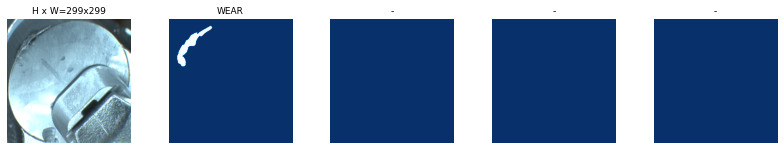

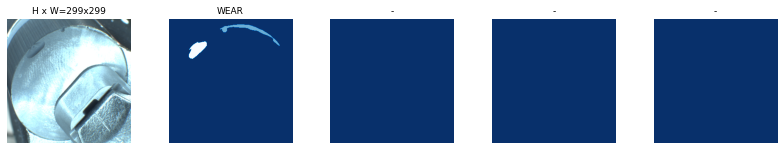

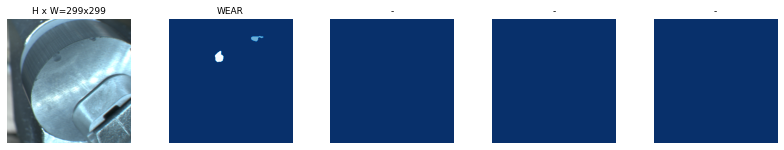

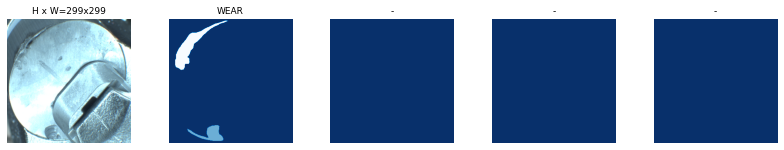

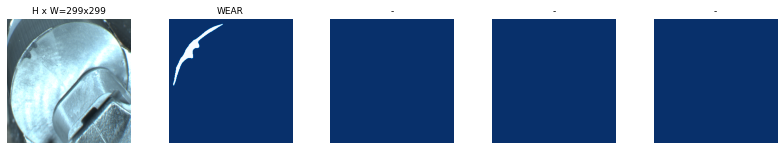

In [8]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_random_samples

visualize_random_samples(dataset_train, 5)

### Configurations

In [7]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from wearconfig import WearConfig

class RNGN19Config(WearConfig):
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 41 # 164 images /4 = 41
    
RNGN19config = RNGN19Config()
RNGN19config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Generalization test - Evaluation from RNGN12 to RNGN19
No training, just evaluation to pass images to stage 2.

In [10]:
class InferenceConfig(RNGN19Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

inference_config = InferenceConfig()
inference_config.display()

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR, tool=tool)

weights_path = "/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RNGN12_WEAR_STAGE1_MRCNN_20220714T1059/mask_rcnn_tool_wear.h5"

# Load trained weights
print("Loading weights from ", weights_path)
model.load_weights(weights_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Visualize ground truth

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
original_image           shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  320.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   17.00000  max:  120.00000  int32
gt_mask                  shape: (320, 320, 1)         min:    0.00000  max:    1.00000  bool


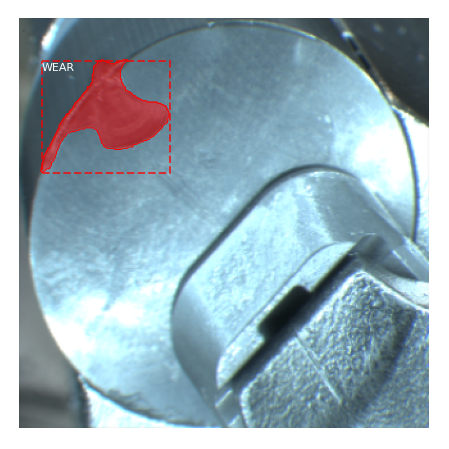

In [11]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_gt

image_id = visualize_gt(dataset_test, inference_config, 3)

### Visualize Predictions

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


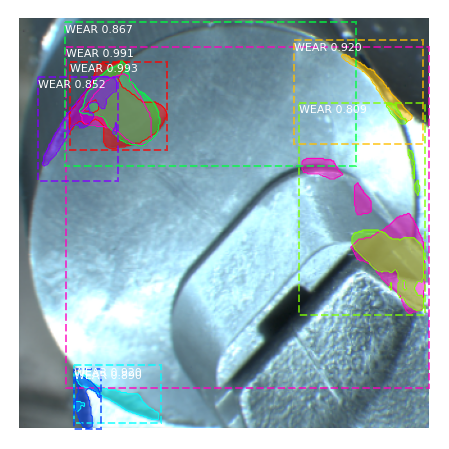

In [12]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model)

#### Adjust bboxes 

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


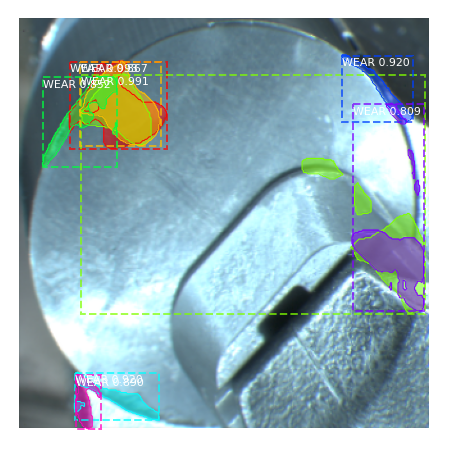

In [13]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model, adjusted=True)

## Evaluation

In [14]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import compute_map

compute_map(dataset_test, inference_config, model)

mAP: 0.384


### Save info in a JSON file for stage2

Working on training set...
wo
Image name:  RNGN19_CFAA0_20211006_000405_wo_cn.bmp
Number of images in training set:  164
Number of images in training set for which at least one confident (>= 0.95 ) mask has been predicted:  162

Working also on validation set...
wo
Image name:  RNGN19_GMTK2_20211004_000305_wo_cn.bmp
Number of images in validation set:  20
Number of images in validation set for which at least one confident (>= 0.95 ) mask has been predicted:  20

Working also on test set...
wo
Image name:  RNGN19_GMTK2_20211004_000232_wo_cn.bmp
Number of images in test set:  47
Number of images in test set for which at least one mask has been predicted:  47
Number of images in test set for which no masks have been predicted, and therefore have  not been cropped and passed down to 2nd stage, but have been only added to the JSON,  so that the 2nd stage can consider them directly as OK, as if the prediction was entirely  performed by the 1st stage:  0
Example of JSON object:  {'name': 'RNG

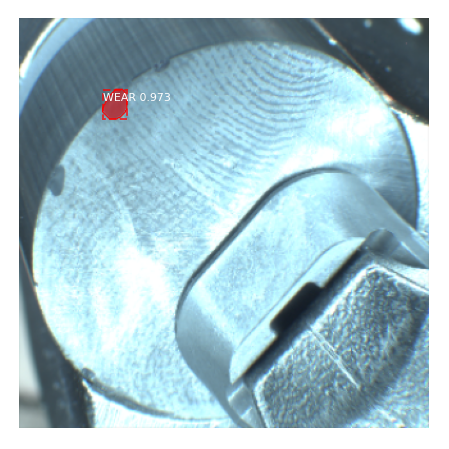

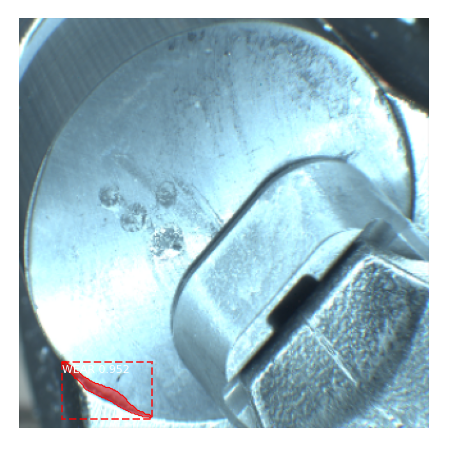

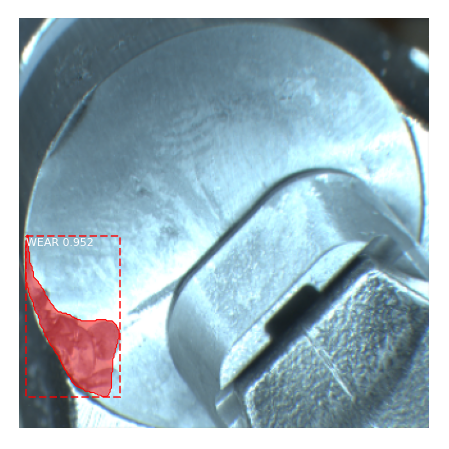

In [15]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import predict_and_prepare_data_for_s2

predict_and_prepare_data_for_s2(dataset_train, dataset_val, dataset_test, inference_config, model, tool, threshold=0.95, visual=True)

Once you reach this point, go perform generalization test for stage 2. Analyse the result, then save checkpoints and re-start from finetuning.

# Stage1 Finetuning
Followed by stage2 finetuning, so evaluation needs to be performed too. Finetuning is done on head layers.

### Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=RNGN19config,
                          model_dir=MODEL_DIR, tool=tool)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


### Restore weights and finetune heads

In [9]:
# Fine-tune the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import keras
import datetime
print("Training network heads")
logdir=os.path.join("/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/tblogs", tool+"_WEAR_STAGE1_MRCNN_TRANSFER_LEARNING_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

model_path = '/content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RNGN12_WEAR_STAGE1_MRCNN_20220714T1059/mask_rcnn_tool_wear.h5' # SET HERE THE ALREADY TRAINED MODEL PATH ON THE FIRST COMPONENT

model.load_weights(model_path, by_name=True)
model.train(dataset_train, dataset_val, 
            learning_rate=RNGN19config.LEARNING_RATE, 
            epochs=200, 
            layers='heads',
            augmentation=augmentation,
            custom_callbacks=[keras.callbacks.TensorBoard(logdir, update_freq="epoch"),
                              keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)])

Training network heads







Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RNGN19_WEAR_STAGE1_MRCNN_20220716T2008/mask_rcnn_tool_wear.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/200
41/41 [==============================] - 72s 2s/step - loss: 1.3347 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6160 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.2125 - val_loss: 1.6005 - val_rpn_class_loss: 0.0482 - val_rpn_bbox_loss: 0.8994 - val_mrcnn_class_loss: 0.0699 - val_mrcnn_bbox_loss: 0.4101 - val_mrcnn_mask_loss: 0.1730

Epoch 00001: val_loss improved from inf to 1.60052, saving model to /content/drive/MyDrive/2022-DC03/Stage1_Mask_RCNN/logs/tool_wear_RNGN19_WEAR_STAGE1_MRCNN_20220716T2008/mask_rcnn_tool_wear.h5

Epoch 2/200
41/41 [==============================] - 18s 444ms/step - loss: 1.2816 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.6324 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3616 - mrcnn_mask_loss: 0.1989 - val_loss: 1.4721 - val_rpn_class_loss: 0.0501 - val_rpn_bbox_loss: 0.8001 - val_mrcnn_class_loss: 0.0632 - val_mrcnn_bbox_loss: 0.3858 - val_mrcnn_mask_loss: 0.1728

Epoch 00002: val_loss improved from 1.60052 to 

### Detection

In [10]:
class InferenceConfig(RNGN19Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

inference_config = InferenceConfig()
inference_config.display()

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR, tool=tool)


# Load trained weights
print("Loading weights from ", model.find_last())
model.load_weights(model.find_last(), by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Visualize ground truth

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
original_image           shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  320.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   17.00000  max:  120.00000  int32
gt_mask                  shape: (320, 320, 1)         min:    0.00000  max:    1.00000  bool


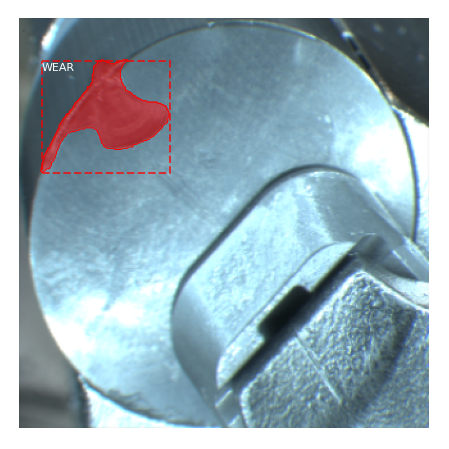

In [11]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_gt

image_id = visualize_gt(dataset_test, inference_config, 3)

### Visualize Predictions

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


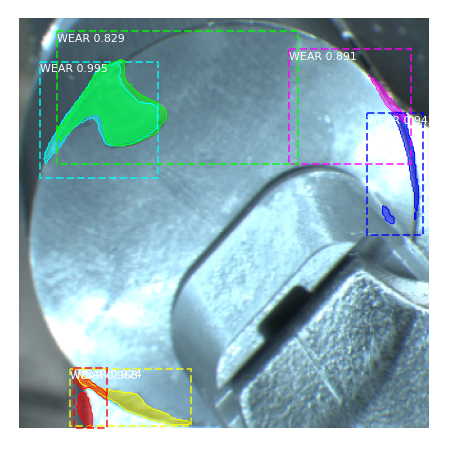

In [12]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model)

#### Adjust bboxes 

Image name:  RNGN19_GMTK2_20211004_000054_wo_cn.bmp
Processing 1 images
image                    shape: (320, 320, 3)         min:    7.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -116.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -0.56746  max:    1.36683  float32


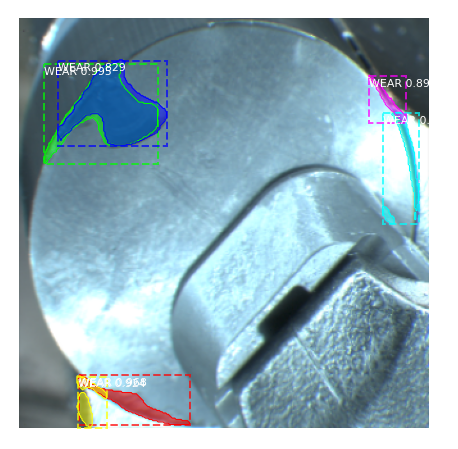

In [13]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import visualize_pred

visualize_pred(dataset_test, inference_config, image_id, model, adjusted=True)

## Evaluation

In [14]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import compute_map

compute_map(dataset_test, inference_config, model)

mAP: 0.541


### Save info in a JSON file for stage2

Working on training set...
wo
Image name:  RNGN19_CFAA0_20211006_000405_wo_cn.bmp
Number of images in training set:  164
Number of images in training set for which at least one confident (>= 0.95 ) mask has been predicted:  159

Working also on validation set...
wo
Image name:  RNGN19_GMTK2_20211004_000305_wo_cn.bmp
Number of images in validation set:  20
Number of images in validation set for which at least one confident (>= 0.95 ) mask has been predicted:  19

Working also on test set...
wo
Image name:  RNGN19_GMTK2_20211004_000232_wo_cn.bmp
Number of images in test set:  47
Number of images in test set for which at least one mask has been predicted:  47
Number of images in test set for which no masks have been predicted, and therefore have  not been cropped and passed down to 2nd stage, but have been only added to the JSON,  so that the 2nd stage can consider them directly as OK, as if the prediction was entirely  performed by the 1st stage:  0
Example of JSON object:  {'name': 'RNG

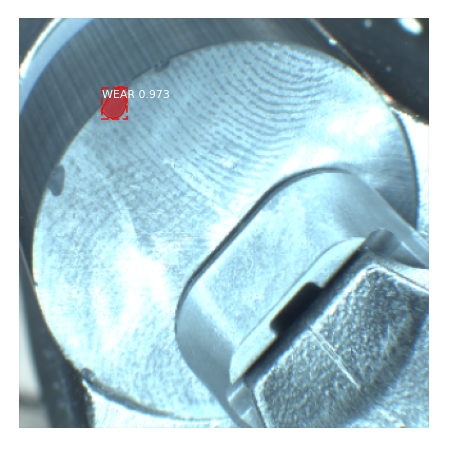

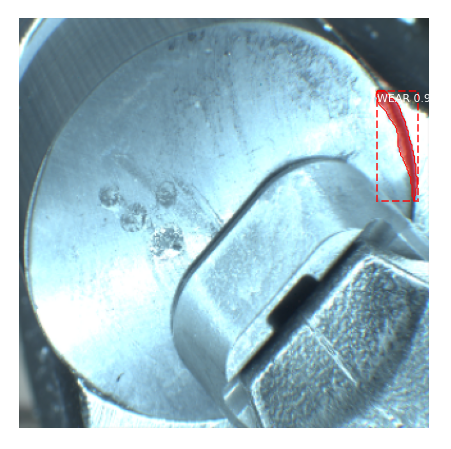

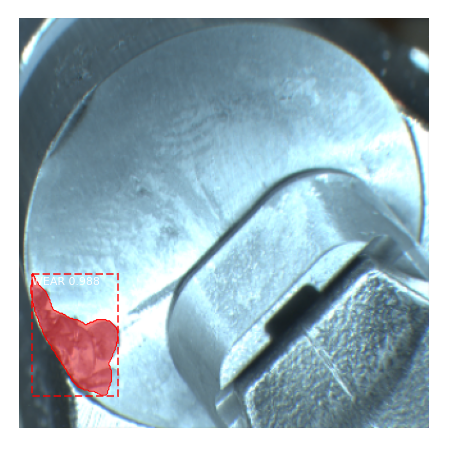

In [15]:
SRC_DIR = os.path.abspath("/content/mlinapptests/src/models/Stage1_Mask_RCNN")

sys.path.append(SRC_DIR)

from utils import predict_and_prepare_data_for_s2

predict_and_prepare_data_for_s2(dataset_train, dataset_val, dataset_test, inference_config, model, tool, threshold=0.95, visual=True)